# Body Fat Predictor Based of BMI and Body Measurements

### Purpose

The purpose of this notebook is to apply the things learned in General Assembly (Singapore)'s batch 5 part-time data science course. 

### Backstory

BMI is a common, but poor indicator used to measure the health of a person. BMI was first widely used in the 1970's as a metric for heart attack chance by insurance companies who wanted an easy way to quantify people. The formula for BMI is given as mass(kg)/height(m)^2. One major problem with BMI is it doesn't take into account individual/racial body differences. Another major problem with BMI is if a person has a lot of muscle, they will be considered obese because the metric only looks at weight, not taking into account if it's fat or muscle. Despite these drawbacks, BMI is easy to administer, resulting it's its wide-spread usage. 

The most accurate way to gauge health is to measure percentage body fat. The price that is paid for accuracy is ease of measuring. Truly accurate fat percentage is measured in a water bath. The displacement of water is then used to calculate a person's fat percentage. However, this requires a sizable amount of time and specialized equipment. Another method typically with 0.5-5.0% error of a water bath are electrical impidance machines. These machines pass a current through a person and measure the amount of resistance to calculate a person's body fat. One drawback of this method is that it requires specialized equipment for true accuracy. 

One method that has been suggested to replace BMI is sagittal abdominal diameter (cm). This is a measurment from the small of the back to the navel. Studies have shown a 5% error compared to percentage body fat measured. It is a relatively easy test to perform and is almost as accurate as percentage body fat measurements. 

In this notebook, we will look at predicting sagittal abdominal diameter from BMI, weight(kg), height(cm), upper leg length (cm), upper arm circumference (cm) and waist circumference (cm). Although it can be argued that this model is unneeded becuase sagittal abdominal diameter can easily be measured, it is interesting to look at as a way to 1) convert older data to more modern standards and 2) there may be cases where the patient is unable to or refuses measurement. In such cases, a model can be used to predict that value in order to complete the data.

Data was taken from the CDC's National Health and Nutrition Examination Survey (NHANES) 2015-2016

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

In [2]:
def plot_correlation_map( df ):
    corr = merge_df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
#from kaggle.com "Titanic An Interactive Data Science Tutorial"

In [3]:
bmx_df = pd.read_csv('csv/bmx_i.csv')
# ^ body measurements file
demo_df = pd.read_csv('csv/demo_i.csv')
# ^ demographics data

In [4]:
bmx_df.columns.values

array(['SEQN', 'BMDSTATS', 'BMXWT', 'BMIWT', 'BMXRECUM', 'BMIRECUM',
       'BMXHEAD', 'BMIHEAD', 'BMXHT', 'BMIHT', 'BMXBMI', 'BMDBMIC',
       'BMXLEG', 'BMILEG', 'BMXARML', 'BMIARML', 'BMXARMC', 'BMIARMC',
       'BMXWAIST', 'BMIWAIST', 'BMXSAD1', 'BMXSAD2', 'BMXSAD3', 'BMXSAD4',
       'BMDAVSAD', 'BMDSADCM'], dtype=object)

In [5]:
demo_df.columns.values

array(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ',
       'DMQADFC', 'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3',
       'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG', 'SIALANG', 'SIAPROXY',
       'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG',
       'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ', 'DMDFMSIZ',
       'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGE',
       'DMDHRBR4', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU', 'WTINT2YR',
       'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2',
       'INDFMPIR'], dtype=object)

In [6]:
bmx_df = bmx_df.drop(['BMXRECUM', 'BMIRECUM', 'BMXHEAD', 'BMIHEAD', 'BMDBMIC', 'BMIHT', 'BMILEG', 'BMIARML',
    'BMIARMC', 'BMIWAIST', 'BMDSADCM',
    'BMDSTATS', 'BMXSAD1', 'BMXSAD2', 'BMXSAD3', 'BMXSAD4', 'BMIWT',
                     ], axis=1)
demo_df = demo_df.drop(['SDDSRVYR', 'RIDSTATR', 'RIDAGEMN', 'RIDRETH1', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC',
    'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP',
    'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE',
    'DMDHRBR4', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR',
    'DMDHRGND', 'DMDHRAGE', 'DMDHREDU', 'DMDHRMAR','DMDHSEDU', 'DMDMARTL', 'DMDEDUC3', 'DMDEDUC2',               
                    ], axis=1)

In [7]:
merge_df = pd.merge(demo_df, bmx_df, how='inner')

In [8]:
merge_df.describe()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMDAVSAD
count,1.116800e+04,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000,11168.000000
mean,7.581835e+04,1.581304,30.727077,3.184456,52.829137,145.761372,23.509653,29.805704,31.404576,26.726254,76.058363,15.758301
std,3.138974e+04,0.493368,22.989024,1.553500,37.349890,44.855141,9.710888,16.082163,9.843889,9.511057,33.669808,9.584680
min,3.687825e-40,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.495375e+04,1.000000,11.000000,2.000000,16.200000,146.600000,19.400000,30.875000,30.000000,22.300000,65.000000,13.200000
50%,8.787650e+04,2.000000,24.000000,3.000000,58.800000,162.800000,22.400000,37.600000,33.800000,26.700000,77.600000,16.900000
75%,9.079325e+04,2.000000,48.000000,4.000000,80.000000,167.900000,29.000000,39.400000,37.400000,32.900000,98.500000,22.300000
max,9.370200e+04,2.000000,80.000000,7.000000,198.900000,202.700000,67.300000,51.500000,47.400000,58.400000,171.600000,40.800000


In [9]:
merge_df.columns.values

array(['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'BMXWT', 'BMXHT',
       'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'BMDAVSAD'], dtype=object)

# Dictionary

- SEQN = respondant sequence number
- RIAGENDR = gender (1=male, 2=female)
- RIDAGEYR = age
- RIDRETH3 = race (1=MexicanAmerican, 2=Other Hispanic, 3=Non-Hispanic White, 4=Non-Hispanic Black, 6=Non-Hispanic Asian, 7=Other inc. multi-racial)
- DMDEDUC3 = education6-19 (0=none/kindergarten, 1=1st, 2=2nd, 3=3rd, 4=4th, 5=5th, 6=6th, 7=7th, 8=8th, 9=9th, 10=10th, 11=11th, 12=12th, 13=HSGraduate, 14=GED or equiv, 15=More than HS, 55=lessthan5th, 66=lessthann9th, 77=refused, 99=don'tknow, .=missing
- DMDEDUC2 = education20+ (1=lessthan9th, 2=9-11th/12th w/ no diploma, 3=HS grad or GED, 4=Some college/AA equiv, 5=College grad, 7=refused, 9=don't know, .=missing
- DMDMARTL = marital status (1=married, 2=widowed, 3=divorced, 4=seperated, 5=nvr married, 6=living w/ partner, 77 = refused, 99=don't know

- BMXWT = weight (KG)
- BMXHT = height (cm)
- BMXBMI = BMI (kg/m**2)
- BMXLEG = upper leg length(cm)
- BMXARML = upper arm length(cm)
- BMXARMC = arm circumference(cm)
- BMXWASIT = waist circumference(cm)
- BMXSAD1-4 = sagittal abdominal diameter (cm)
- BMXAVSAD = avg. sagittal abdominal diameter (cm) good <=25cm; bad >=30cm

# Fixing category values

In [10]:
merge_df = pd.get_dummies(merge_df,columns=["RIDRETH3", "RIAGENDR"], drop_first=True )

In [11]:
merge_df.columns.values

array(['SEQN', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML',
       'BMXARMC', 'BMXWAIST', 'BMDAVSAD', 'RIDRETH3_2', 'RIDRETH3_3',
       'RIDRETH3_4', 'RIDRETH3_6', 'RIDRETH3_7', 'RIAGENDR_2'], dtype=object)

# Dropping values from features

In [12]:
merge_df[merge_df['RIDAGEYR'] <= 7] = np.NaN
merge_df[merge_df['BMXWT'] <= 1] = np.NaN
merge_df[merge_df['BMXHT'] <= 0] = np.NaN
merge_df[merge_df['BMXBMI'] <= 0] = np.NaN
merge_df[merge_df['BMXLEG'] <= 0] = np.NaN
merge_df[merge_df['BMXARML'] <= 0] = np.NaN
merge_df[merge_df['BMXARMC'] <= 0] = np.NaN
merge_df[merge_df['BMXWAIST'] <= 0] = np.NaN
merge_df[merge_df['BMDAVSAD'] <= 0] = np.NaN

merge_df = merge_df.dropna()

merge_df.describe()

,SEQN,RIDAGEYR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMDAVSAD,RIDRETH3_2,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,RIAGENDR_2
count,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000,6909.000000
mean,88726.754813,38.608771,73.888710,162.997988,27.316949,38.124663,36.166811,31.229975,93.146374,21.228745,0.133594,0.314228,0.214069,0.111304,0.042264,0.502678
std,2876.609802,22.020979,24.364478,13.005450,7.267979,4.165021,3.581956,6.084942,19.279862,4.977972,0.340240,0.464241,0.410204,0.314531,0.201205,0.500029
min,83732.000000,8.000000,17.700000,111.800000,12.300000,24.000000,22.500000,15.200000,45.200000,9.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,86229.000000,17.000000,58.200000,155.600000,22.100000,35.300000,34.000000,27.100000,79.200000,17.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88743.000000,37.000000,72.300000,163.900000,26.500000,38.300000,36.500000,31.200000,93.000000,20.900000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,91217.000000,57.000000,88.200000,172.000000,31.400000,41.000000,38.600000,35.300000,105.600000,24.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,93702.000000,80.000000,198.900000,202.700000,64.600000,51.100000,47.400000,54.400000,171.600000,40.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualizing Heat Maps

In [13]:
merge_df.head()

,SEQN,RIDAGEYR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMDAVSAD,RIDRETH3_2,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,RIAGENDR_2
0,83732.0,62.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,22.8,0.0,1.0,0.0,0.0,0.0,0.0
1,83733.0,53.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,27.3,0.0,1.0,0.0,0.0,0.0,0.0
2,83734.0,78.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,26.6,0.0,1.0,0.0,0.0,0.0,0.0
3,83735.0,56.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,25.1,0.0,1.0,0.0,0.0,0.0,1.0
5,83737.0,72.0,64.4,150.0,28.6,34.4,33.5,31.4,92.9,23.1,0.0,0.0,0.0,0.0,0.0,1.0


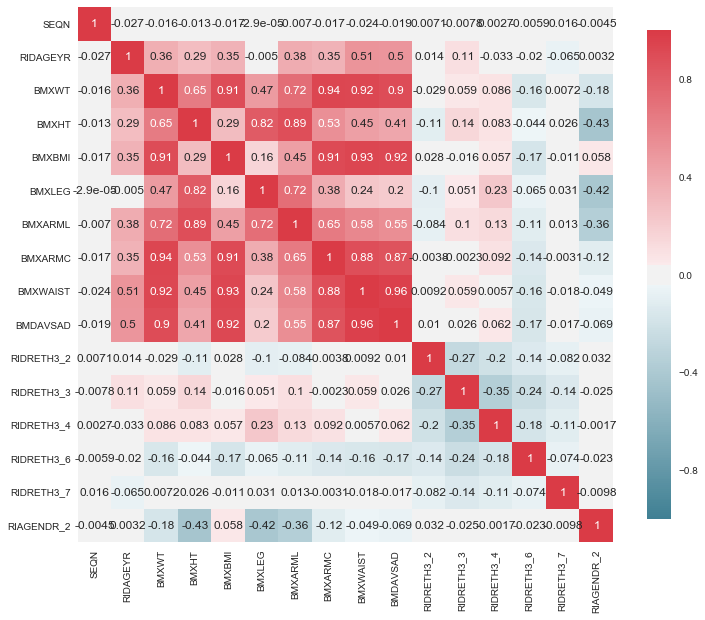

In [14]:
plot_correlation_map(merge_df)

In [15]:
merge_df[['RIDAGEYR', 'BMDAVSAD']].groupby(['RIDAGEYR'], as_index=False).mean()#.sort_values(by='BMDAVSAD', ascending=False)

,RIDAGEYR,BMDAVSAD
0,8.0,14.323041
1,9.0,14.911282
2,10.0,15.811765
3,11.0,16.466667
4,12.0,17.193377
5,13.0,17.532143
6,14.0,18.173964
7,15.0,18.310256
8,16.0,18.520000
9,17.0,19.000000


In [16]:
merge_df[['BMXWT', 'BMDAVSAD']].groupby(['BMXWT'], as_index=False).mean()#.sort_values(by='BMDAVSAD', ascending=False)

,BMXWT,BMDAVSAD
0,17.7,9.800000
1,17.9,11.200000
2,19.2,12.800000
3,20.1,12.450000
4,20.3,11.600000
5,20.7,10.900000
6,20.9,13.100000
7,21.4,12.800000
8,21.5,9.600000
9,21.6,10.600000


In [17]:
merge_df[['BMXBMI', 'BMDAVSAD']].groupby(['BMXBMI'], as_index=False).mean()#.sort_values(by='BMXBMI', ascending=False)

,BMXBMI,BMDAVSAD
0,12.3,10.500000
1,12.7,13.100000
2,12.9,10.900000
3,13.1,12.400000
4,13.3,11.300000
5,13.4,11.550000
6,13.5,10.800000
7,13.7,11.350000
8,13.8,12.200000
9,13.9,11.433333


In [18]:
merge_df[['BMXLEG', 'BMDAVSAD']].groupby(['BMXLEG'], as_index=False).mean()#.sort_values(by='BMDAVSAD', ascending=False)

,BMXLEG,BMDAVSAD
0,24.0,12.800000
1,25.2,12.000000
2,25.3,13.000000
3,25.4,9.800000
4,25.5,12.300000
5,26.0,26.400000
6,26.2,13.000000
7,26.3,10.600000
8,26.4,24.200000
9,26.5,11.933333


In [19]:
merge_df[['BMXARML', 'BMDAVSAD']].groupby(['BMXARML'], as_index=False).mean()#.sort_values(by='BMDAVSAD', ascending=False)

,BMXARML,BMDAVSAD
0,22.5,12.800000
1,23.0,9.600000
2,23.5,12.000000
3,24.0,14.250000
4,24.5,13.100000
5,24.6,10.200000
6,24.8,11.600000
7,25.0,12.366667
8,25.2,12.375000
9,25.3,13.350000


In [20]:
merge_df[['BMXARMC', 'BMDAVSAD']].groupby(['BMXARMC'], as_index=False).mean()#.sort_values(by='BMDAVSAD', ascending=False)

,BMXARMC,BMDAVSAD
0,15.2,11.400000
1,15.4,9.800000
2,16.4,10.900000
3,16.5,12.400000
4,16.6,11.500000
5,16.7,12.750000
6,16.8,10.800000
7,16.9,12.450000
8,17.0,11.700000
9,17.1,18.300000


In [21]:
merge_df[['BMXWAIST', 'BMDAVSAD']].groupby(['BMXWAIST'], as_index=False).mean()#.sort_values(by='BMDAVSAD', ascending=False)

,BMXWAIST,BMDAVSAD
0,45.2,9.800000
1,48.9,11.200000
2,49.1,11.600000
3,49.5,10.900000
4,49.9,10.600000
5,50.9,11.500000
6,51.0,13.900000
7,51.1,11.600000
8,51.5,11.325000
9,51.7,11.600000


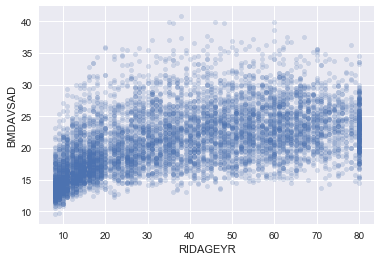

In [22]:
merge_df.plot(kind='scatter', x='RIDAGEYR', y='BMDAVSAD', alpha=0.2)

# Scatter Plots Looking at Features vs. Avg. Sagittal Abdominal Diameter

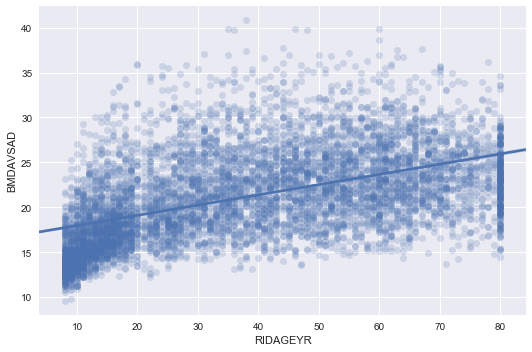

In [23]:
sns.lmplot(x='RIDAGEYR', y='BMDAVSAD', data=merge_df, aspect=1.5, scatter_kws={'alpha':0.2})

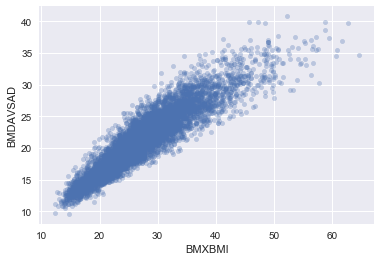

In [24]:
merge_df.plot(kind='scatter', x='BMXBMI', y='BMDAVSAD', alpha=0.3)

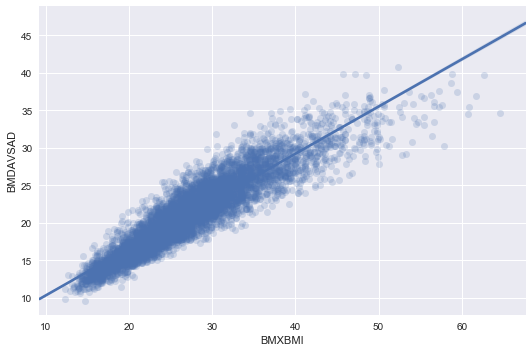

In [25]:
sns.lmplot(x='BMXBMI', y='BMDAVSAD', data=merge_df, aspect=1.5, scatter_kws={'alpha':0.2})

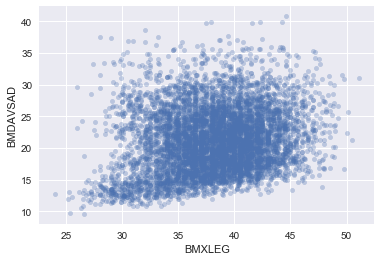

In [26]:
merge_df.plot(kind='scatter', x='BMXLEG', y='BMDAVSAD', alpha=0.3)

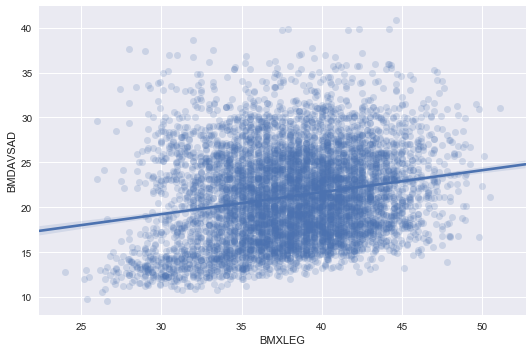

In [27]:
sns.lmplot(x='BMXLEG', y='BMDAVSAD', data=merge_df, aspect=1.5, scatter_kws={'alpha':0.2})

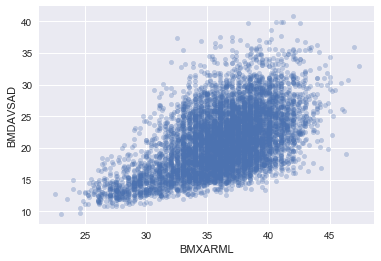

In [28]:
merge_df.plot(kind='scatter', x='BMXARML', y='BMDAVSAD', alpha=0.3)

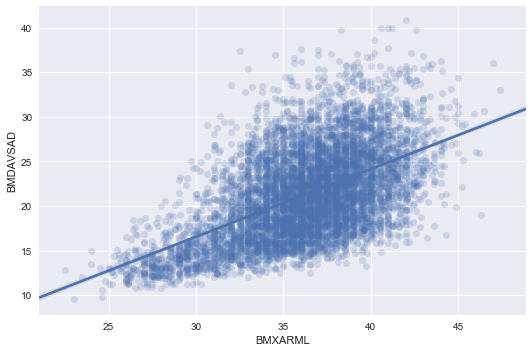

In [29]:
sns.lmplot(x='BMXARML', y='BMDAVSAD', data=merge_df, aspect=1.5, scatter_kws={'alpha':0.2})

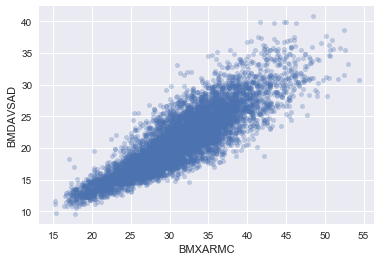

In [30]:
merge_df.plot(kind='scatter', x='BMXARMC', y='BMDAVSAD', alpha=0.3)

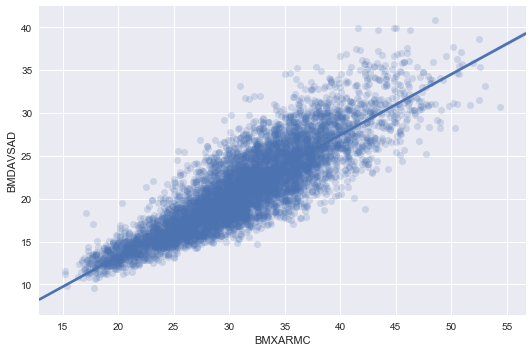

In [31]:
sns.lmplot(x='BMXARMC', y='BMDAVSAD', data=merge_df, aspect=1.5, scatter_kws={'alpha':0.2})

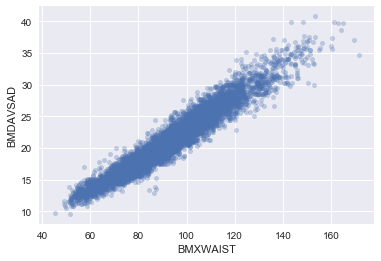

In [32]:
merge_df.plot(kind='scatter', x='BMXWAIST', y='BMDAVSAD', alpha=0.3)

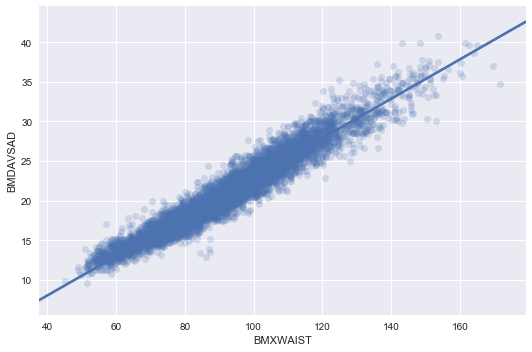

In [33]:
sns.lmplot(x='BMXWAIST', y='BMDAVSAD', data=merge_df, aspect=1.5, scatter_kws={'alpha':0.2})

# Splitting Data Frame & Creating Training/Test Sets

In [34]:
train_df, test_df = train_test_split(merge_df, test_size=0.2)

In [35]:
print merge_df.shape, train_df.shape, test_df.shape



(6909, 16) (5527, 16) (1382, 16)


In [36]:
X_train = train_df.drop(['SEQN', 'BMDAVSAD'], axis=1)
Y_train = train_df['BMDAVSAD']
X_test = test_df.drop(['SEQN', 'BMDAVSAD'], axis=1)
Y_test = test_df['BMDAVSAD']
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5527, 14), (5527,), (1382, 14), (1382,))

# Linear Regression

In [37]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
assorted_pred = linreg.predict(X_test)
acc_lin = round(linreg.score(X_train, Y_train) * 100, 2)
acc_lin


93.99

In [38]:
acc_lin_test = round(linreg.score(X_test, Y_test) * 100, 2)
acc_lin_test


94.35

In [39]:
coeff_df = pd.DataFrame(train_df.columns)
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(linreg.coef_)

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
10,RIDRETH3_2,0.694741
12,RIDRETH3_4,0.277228
7,BMXARMC,0.174032
3,BMXHT,0.102941
8,BMXWAIST,0.097859
1,RIDAGEYR,0.041150
0,SEQN,0.013959
9,BMDAVSAD,0.013290
5,BMXLEG,-0.003801
2,BMXWT,-0.012599


# Support Vector Regression

In [40]:
# Support Vector Regression

svr = SVR()
svr.fit(X_train, Y_train)
Y_pred = svr.predict(X_test)
acc_svr = round(svr.score(X_train, Y_train) * 100, 2)
acc_svr

54.75

In [41]:
acc_svr_test = round(svr.score(X_test, Y_test) * 100, 2)
acc_svr_test

35.4

# KNN

In [42]:
knn = KNeighborsRegressor()
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

94.96

In [43]:
acc_knn_test = round(knn.score(X_test, Y_test) * 100, 2)
acc_knn_test

93.14

In [46]:
grid = GridSearchCV(knn, param_grid={'n_neighbors': range(1,101)})
grid.fit(X_test, Y_test)
print(grid)
# summarize the results of the grid search
acc_knn_test = round(grid.best_score_ *100, 2)
print(acc_knn_test)
print(grid.best_estimator_)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
93.21
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=2,
          weights='uniform')


# Linear SVR

In [47]:
linear_svr = LinearSVR()
linear_svr.fit(X_train, Y_train)
Y_pred = linear_svr.predict(X_test)
acc_linear_svr = round(linear_svr.score(X_train, Y_train) * 100, 2)
acc_linear_svr

83.79

In [48]:
acc_linear_svr_test = round(linear_svr.score(X_test, Y_test) * 100, 2)
acc_linear_svr_test

84.49

# Decision Tree

In [49]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

In [50]:
acc_decision_tree_test = round(decision_tree.score(X_test, Y_test) * 100, 2)
acc_decision_tree_test

87.99

# Random Forest

In [51]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.76

In [52]:
acc_random_forest_test = round(random_forest.score(X_test, Y_test) * 100, 2)
acc_random_forest_test

93.73

In [53]:
random_forest.get_params().keys()

['warm_start',
 'oob_score',
 'n_jobs',
 'verbose',
 'max_leaf_nodes',
 'bootstrap',
 'min_samples_leaf',
 'n_estimators',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'criterion',
 'random_state',
 'min_impurity_split',
 'max_features',
 'max_depth']

In [54]:
grid = GridSearchCV(random_forest, param_grid={'n_estimators': range(1,101)})
grid.fit(X_test, Y_test)
print(grid)
# summarize the results of the grid search
acc_random_forest_test = round(grid.best_score_ * 100, 2)
print(acc_random_forest_test)
print(grid.best_estimator_)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
93.82
Ran

# Comparing Prediction Scores

In [55]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Linear Regression',
             'Random Forest',
             'Linear SVR',
             'Decision Tree'],
    'Score - Train': [acc_svr, acc_knn, acc_lin, acc_random_forest,
             acc_linear_svr,
             acc_decision_tree],
    'Score - Test': [acc_svr_test, acc_knn_test, acc_lin_test, acc_random_forest_test,
             acc_linear_svr_test,
             acc_decision_tree_test]})
models.sort_values(by='Score - Test', ascending=False)

,Model,Score - Test,Score - Train
2,Linear Regression,94.35,93.99
3,Random Forest,93.82,98.76
1,KNN,93.21,94.96
5,Decision Tree,87.99,100.00
4,Linear SVR,84.49,83.79
0,Support Vector Machines,35.40,54.75
